# Atmospheric drag

In this section, we will formulate the perturbation experienced by an Earth-orbiting spacecraft due to the Earth's atmosphere.

## Theoretical background

We begin with the formula for the acceleration induced by [quadratic drag](https://en.wikipedia.org/wiki/Drag_(physics)#The_drag_equation) on a spacecraft:

$$
\mathbf{a}_D = -\frac{1}{2}\rho v_{\mathrm{rel}} \frac{C_DA}{m} \mathbf{v}_{\mathrm{rel}},
$$

where $\mathbf{v}_{\mathrm{rel}}$ is the velocity of the spacecraft relative to the atmosphere, $v_{\mathrm{rel}}=\left| \mathbf{v}_{\mathrm{rel}} \right|$, $\rho$ is the atmospheric density and $C_D$, $A$ and $m$ are, respectively, the [drag coefficient](https://en.wikipedia.org/wiki/Drag_coefficient), [cross sectional area](https://en.wikipedia.org/wiki/Cross_section_(geometry)) and mass of the spacecraft. An equivalent formulation is:

$$
\mathbf{a}_D = -\frac{1}{2}\rho v_{\mathrm{rel}}C_b \mathbf{v}_{\mathrm{rel}},
$$

where $C_b=\frac{C_DA}{m}$ is the [ballistic coefficient](https://en.wikipedia.org/wiki/Ballistic_coefficient) of the spacecraft (or its inverse, depending on the convention).

The air density $\rho$ can be calculated from a standard atmospheric model, where it is typically given as a function of the position of the spacecraft in an Earth-fixed frame, a time coordinate and solar weather indices. Here we will be using our own implementation of the [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) atmospheric model, described in detail in [another tutorial](<./thermoNETs.ipynb>).

Unless otherwise noted, we will be operating in SI units, with time counted in [TT](https://en.wikipedia.org/wiki/Terrestrial_Time) seconds since J2000.

## Coordinate transformations

While spacecraft dynamics is most easily formulated in a non-rotating reference frame (such as the [GCRS](https://en.wikipedia.org/wiki/Barycentric_and_geocentric_celestial_reference_systems)), we will need to rotate to an Earth-fixed frame (such as the [ITRS](https://en.wikipedia.org/wiki/ITRS)) in order to compute $\rho$ and $\mathbf{v}_{\mathrm{rel}}$.

We start off by introducing $x,y,z$ as the Cartesian coordinates of the spacecraft in the GCRS:

In [1]:
import heyoka as hy

# Cartesian coordinates in the GCRS.
x, y, z = hy.make_vars("x", "y", "z")

The Cartesian coordinates in the ITRS $x_{\mathrm{ITRS}},y_{\mathrm{ITRS}},z_{\mathrm{ITRS}}$ are related to $x,y,z$ by a complex time-dependent relation (which also involves [Earth orientation parameters data](<./eop_data.ipynb>)). The rotation can be performed via the {py:func}`~heyoka.model.rot_icrs_itrs()` function:

In [2]:
# Seconds in a day.
sday = 86400.0
# Days in a century.
dcy = 36525.0

# Introduce the time variable, measuring time in seconds.
tm = hy.make_vars("tm")

# Perform the rotation.
x_itrs, y_itrs, z_itrs = hy.model.rot_icrs_itrs(
    [x, y, z], thresh=1e-3, time_expr=tm / (sday * dcy)
)

Notice how we passed ``tm / (sday * dcy)`` as the ``time_expr`` argument in {py:func}`~heyoka.model.rot_icrs_itrs()`. The reason for this is that {py:func}`~heyoka.model.rot_icrs_itrs()` requires in input the number of **centuries** elapsed since the epoch of J2000, but here we want to formulate the equations of motion in SI units. Hence, we introduce a variable ``tm`` intended to represent time in seconds, and we rescale it in order to produce an expression representing time in centuries.

Notice also how we passed a ``thresh`` argument of $10^{-3}$: this will slightly reduce the accuracy of the rotation in order to improve computational performance. Please see the documentation of {py:func}`~heyoka.model.rot_icrs_itrs()` for more details.

We now need to apply a further transformation in order to account for the fact that atmospheric models typically accept in input [geodetic coordinates](https://en.wikipedia.org/wiki/Geodetic_coordinates). We can accomplish this via the {py:func}`~heyoka.model.cart2geo()` function:

In [3]:
h, lat, lon = hy.model.cart2geo([x_itrs, y_itrs, z_itrs])

Lastly, we need to compute $\mathbf{v}_{\mathrm{rel}}$. In order to do this, we first introduce the variables $v_x, v_y, v_z$ representing the spacecraft's Cartesian velocity components in the GCRS:

In [4]:
vx, vy, vz = hy.make_vars("vx", "vy", "vz")

We then have to compute the atmosphere's velocity at the spacecraft position. In order to do this, we proceed in stages.

First, under the assumption of an atmosphere co-rotating with the Earth, we introduce a point with **fixed** ITRS coordinates $\left( x_0, y_0, z_0 \right)$: 

In [5]:
x0, y0, z0 = hy.make_vars("x0", "y0", "z0")

Then, we apply an ITRS->GCRS rotation in order to calculate the point's Cartesian position in the GCRS:

In [6]:
x0_gcrs, y0_gcrs, z0_gcrs = hy.model.rot_itrs_icrs(
    [x0, y0, z0], thresh=1e-3, time_expr=tm / (sday * dcy)
)

We then take the time derivative in order to produce expressions for the velocity components of the fixed point in the GCRS:

In [7]:
vx0_gcrs, vy0_gcrs, vz0_gcrs = hy.diff_tensors(
    [x0_gcrs, y0_gcrs, z0_gcrs], diff_args=[tm]
).jacobian.flatten()

Finally, we replace $\left( x_0, y_0, z_0 \right)$ with $\left( x_{\mathrm{ITRS}},y_{\mathrm{ITRS}},z_{\mathrm{ITRS}} \right)$. This will yield the atmosphere's GCRS velocity as a function of the spacecraft's GCRS position:

In [8]:
vx_atm, vy_atm, vz_atm = hy.subs(
    [vx0_gcrs, vy0_gcrs, vz0_gcrs], {x0: x_itrs, y0: y_itrs, z0: z_itrs}
)

$\mathbf{v}_{\mathrm{rel}}$ is now easily computed as $\mathbf{v} - \mathbf{v}_{\mathrm{atm}}$:

In [9]:
vrel_x, vrel_y, vrel_z = vx - vx_atm, vy - vy_atm, vz - vz_atm

## The atmospheric model

As mentioned earlier, we will be using the [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) atmospheric model, implemented in heyoka.py via the {py:func}`~heyoka.model.nrlmsise00_tn()` function. In addition to the geodetic coordinates of the spacecraft, the model requires in input several space weather parameters. Please see the [space weather](<./sw_data.ipynb>) tutorial for more information on how to manage space weather data in heyoka.py.

We begin with the definition of the time coordinate for the model. As the documentation of {py:func}`~heyoka.model.nrlmsise00_tn()` indicates, the time coordinate is expected to represent the number of fractional days elapsed since January 1st UTC 00:00. We can use the handy {py:func}`~heyoka.model.dayfrac()` function for this purpose:

In [10]:
# Time coordinate for use in the atmospheric model.
tm_atm = hy.model.dayfrac(tm / sday)

Again, we rescale ``tm`` by ``sday`` because the {py:func}`~heyoka.model.dayfrac()` function expects an input time measured in days, while ``tm`` measures time in seconds.

Next, we introduce the space weather indices, using the {py:func}`~heyoka.model.f107()`, {py:func}`~heyoka.model.f107a_center81()` and {py:func}`~heyoka.model.Ap_avg()` functions:

In [11]:
f107 = hy.model.f107((tm - sday) / (sday * dcy))
f107a = hy.model.f107a_center81(tm / (sday * dcy))
ap = hy.model.Ap_avg(tm / (sday * dcy))

Notice the offsetting by a day of the time coordinate passed to {py:func}`~heyoka.model.f107()`: as indicated in the documentation of {py:func}`~heyoka.model.nrlmsise00_tn()`, the ``f107`` index of the day  **before** ``tm`` must be used.

We can now assemble the expression for the air density:

In [12]:
rho = hy.model.nrlmsise00_tn(
    [h / 1000.0, lat, lon], f107=f107, f107a=f107a, ap=ap, time_expr=tm_atm
)

Note how we divided ``h`` by 1000: this is because we are measuring ``h`` in metres, but the {py:func}`~heyoka.model.nrlmsise00_tn()` function requires an altitude in kilometres instead.

## Assembling the dynamics

We can now proceed to the formulation of the drag-induced acceleration.

First we compute $v_\mathrm{rel}$:

In [13]:
vrel = hy.sqrt(hy.sum([vrel_x**2, vrel_y**2, vrel_z**2]))

The ballistic coefficient $C_b$ is easily introduced as a [runtime parameter](<./ODEs with parameters.ipynb>):

In [14]:
Cb = hy.par[0]

We can now assemble the expression fo the drag-induced acceleration:

In [15]:
import numpy as np

acc_drag = -0.5 * rho * vrel * Cb * np.array([vrel_x, vrel_y, vrel_z])

As a final step, we replace the time variable ``tm`` with the {py:attr}`heyoka.time` expression. In the previous steps, it was convenient to represent time via a regular variable (so that, e.g., we could take the time derivative in order to compute the atmospheric velocity). For use in ODE integration, however, time **must** be represented via the {py:attr}`heyoka.time` expression:

In [16]:
acc_drag = hy.subs(acc_drag, {tm: hy.time})

## Visualising the drag acceleration

We can now proceed to a visual qualitative check of the computed drag acceleration.

First, we introduce a value for the ballistic coefficient of our spacecraft:

In [17]:
Cb_val = 0.00019366446 * 2 / 0.15696615

This value has been computed from the [BSTAR coefficient](https://en.wikipedia.org/wiki/BSTAR) of the [Hubble space telescope](https://en.wikipedia.org/wiki/Hubble_Space_Telescope) as published on [CelesTrak](https://celestrak.org/).

We then proceed to introduce a [compiled function](<./compiled_functions.ipynb>) for the numerical computation of the drag acceleration:

In [18]:
cf_acc_drag = hy.cfunc(acc_drag, [x, y, z, vx, vy, vz], compact_mode=True)

As a first check, we can visualise how the drag acceleration changes with the orbital radius. For this computation, we fix the time coordinate at $t=0$, that is, J2000:

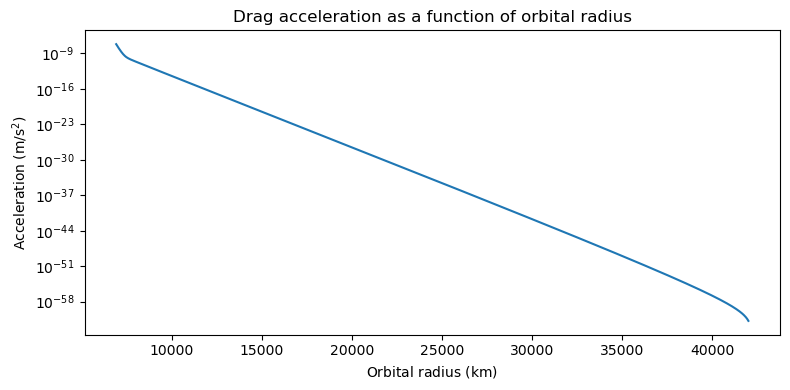

In [19]:
Nsamples = 1000

# Prepare the x/y/z/vx/vy/vz inputs. We use circular equatorial orbits
# of increasing radius.
earth_mu = 3.986e14
inputs = np.zeros((6, Nsamples))
xrange = np.linspace(6.910e6, 4.2e7, Nsamples)
# Initial x coordinate.
inputs[0] = xrange
# Initial vy velocity.
inputs[4] = np.sqrt(earth_mu / xrange)

# Compute and visualise the acceleration.
acc_r = np.linalg.norm(
    cf_acc_drag(inputs, pars=[[Cb_val] * Nsamples], time=[0.0] * Nsamples), axis=0
)

%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 4))

plt.semilogy(xrange / 1000.0, acc_r)

plt.title("Drag acceleration as a function of orbital radius")
plt.xlabel(r"Orbital radius $\left( \mathrm{km} \right)$")
plt.ylabel(r"Acceleration $\left(\mathrm{m}/\mathrm{s}^2\right)$")

plt.tight_layout()

We can see how the acceleration starts at $\sim 10^{-7}\,\mathrm{m}/\mathrm{s}^2$ in LEO, and decays exponentially as the orbital radius increases.

Next, we look at the time evolution of the drag acceleration in LEO. First we look at the evolution over 1 year starting from J2000:

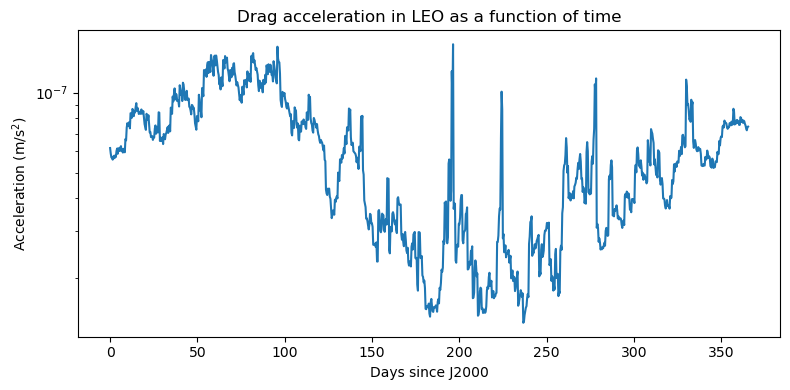

In [20]:
inputs = np.zeros((6, Nsamples))
trange = np.linspace(0, 86400 * 365.25, Nsamples)
inputs[0] = 6.910e6
inputs[4] = np.sqrt(earth_mu / 6.910e6)

acc_hist = np.linalg.norm(
    cf_acc_drag(inputs, pars=[[Cb_val] * Nsamples], time=trange), axis=0
)

fig = plt.figure(figsize=(8, 4))

plt.semilogy(trange / 86400, acc_hist)

plt.title("Drag acceleration in LEO as a function of time")
plt.xlabel(r"Days since J2000")
plt.ylabel(r"Acceleration $\left(\mathrm{m}/\mathrm{s}^2\right)$")

plt.tight_layout()

We can clearly see a noisy yearly cycle punctuated by occasional spikes due to geomagnetic storms.

We can broaden the time horizon and look at the evolution over 22 years (roughly 2 [solar cycles](https://en.wikipedia.org/wiki/Solar_cycle)):

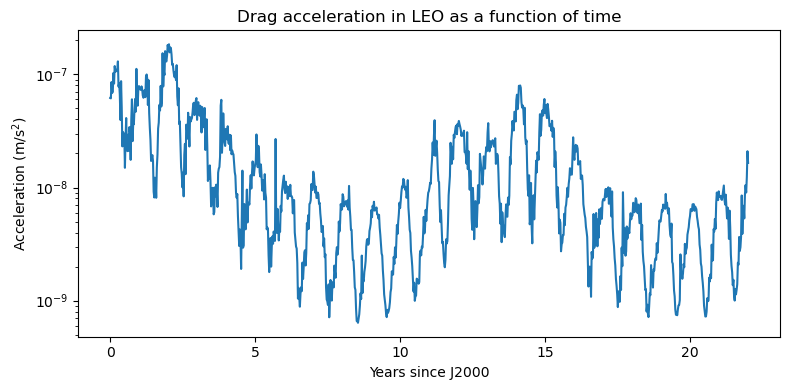

In [21]:
trange = np.linspace(0, 86400 * 365.25 * 22, Nsamples)

acc_hist = np.linalg.norm(
    cf_acc_drag(inputs, pars=[[Cb_val] * Nsamples], time=trange), axis=0
)

fig = plt.figure(figsize=(8, 4))

plt.semilogy(trange / (86400 * 365.25), acc_hist)

plt.title("Drag acceleration in LEO as a function of time")
plt.xlabel(r"Years since J2000")
plt.ylabel(r"Acceleration $\left(\mathrm{m}/\mathrm{s}^2\right)$")

plt.tight_layout()

We can see again the yearly variations superimposed over the longer 11-year period of the solar cycle. Note how the drag acceleration can change by two orders of magnitude between solar maximum and solar minimum.

## An example of orbital decay

In this last section, we will plug the drag acceleration into an ODE solver in order to show a concrete example of orbital decay.

In order to keep things simple, we will assume a Keplerian model for the Earth's gravitational field. We can use the {py:func}`~heyoka.model.fixed_centres()` function for this purpose:

In [22]:
# Define Keplerian dynamics.
dyn = hy.model.fixed_centres(earth_mu, [1.0], [[0.0, 0.0, 0.0]])

We can then add the drag acceleration terms:

In [23]:
dyn[3] = (dyn[3][0], dyn[3][1] + acc_drag[0])
dyn[4] = (dyn[4][0], dyn[4][1] + acc_drag[1])
dyn[5] = (dyn[5][0], dyn[5][1] + acc_drag[2])

In order to detect orbital decay, we will be using a [terminal event](<./Event detection.ipynb>), with a reentry radius of $6491\,\mathrm{km}$:

In [24]:
decay_ev = hy.t_event(x**2 + y**2 + z**2 - (6.491e6) ** 2)

We can now instantiate the numerical integrator, placing our spacecraft on a Keplerian equatorial orbit at an altitude similar to the [ISS](https://en.wikipedia.org/wiki/International_Space_Station):

In [25]:
r0 = 6.778e6
ta = hy.taylor_adaptive(
    dyn,
    [r0, 0.0, 0.0, 0.0, np.sqrt(earth_mu / r0), 0.0],
    t_events=[decay_ev],
    compact_mode=True,
    # NOTE: remember to assign the ballistic coefficient
    # to the pars array.
    pars = [Cb_val]
)

And we let it run until decay, making sure to enable [continuous output](<./Dense output.ipynb>) so that we will be able to analyze the trajectory:

In [26]:
# Propagate for a long time, relying on the decay event to trigger in
# order to stop the integration.
res = ta.propagate_until(1e9, c_output=True)

We can now proceed to examine the results. First, we take a look at the time at which the reentry occurred:

In [27]:
print(f'Reentry time: {ta.time / 86400.} days after J2000')

Reentry time: 895.0561278122303 days after J2000


Second, we can plot the evolution of the radial coordinate of the spacecraft over time, which will give us a qualitative idea of the reentry profile:

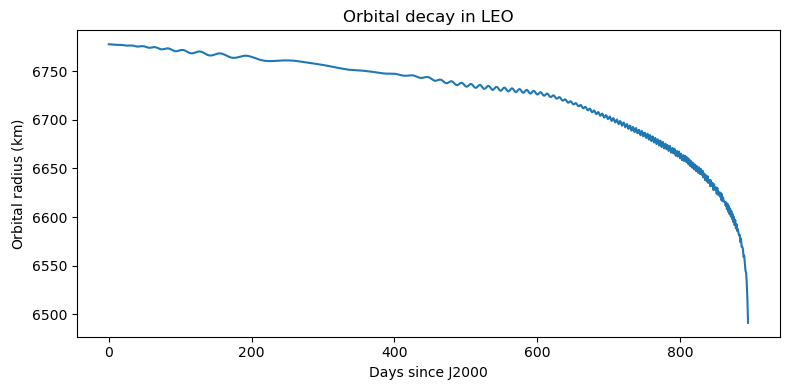

In [28]:
trange = np.linspace(0, ta.time, Nsamples)

r_hist = np.linalg.norm(
    res[4](trange)[:,:3], axis=1
)

fig = plt.figure(figsize=(8, 4))

plt.plot(trange / 86400, r_hist / 1000.)

plt.title("Orbital decay in LEO")
plt.xlabel("Days since J2000")
plt.ylabel(r"Orbital radius $\left(\mathrm{km}\right)$")

plt.tight_layout()

As expected, the decay of the orbital radius is gentle at first. As the atmospheric density increases, the decay rate begins to accelerate, eventually leading to a very steep profile in the final phases of the reentry. 